In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

import copy

In [2]:
import configuration
config = configuration.Config()

In [3]:
from utils_model_sampling import sample_models_across_time
from utils import load_models

In [4]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

In [5]:
config.scores_dir

'experiments/no_versioning/scores/n=2/val'

## Note: running on unigram scores that may not be fully correct -- will correct when OM is back up.

In [6]:

raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order())

# Remove 0.5 and 4.0 because they are sparse.
raw_scores_across_time = raw_scores_across_time[~raw_scores_across_time.age.isin({0.5, 4.0})]


experiments/no_versioning/scores/n=2/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_1.0.pkl
REMOVE THIS TEMPORARY SECTION IN SAMPLE_MODELS_ACROSS_TIME, only used for loading temp scores n = 2
experiments/no_versioning/scores/n=2/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_4.0.pkl
REMOVE THIS TEMPORARY SECTION IN SAMPLE_MODELS_ACROSS_TIME, only used for loading temp scores n = 2
experiments/no_versioning/scores/n=2/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_2.0.pkl
REMOVE THIS TEMPORARY SECTION IN SAMPLE_MODELS_ACROSS_TIME, only used for loading temp scores n = 2
experiments/no_versioning/scores/n=2/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_0.5.pkl
REMOVE THIS TEMPORARY SECTION IN SAMPLE_MODELS_ACROSS_TIME, only used for loading temp scores n = 2
experiments/no_versioning/scores/n=2/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_2.5

REMOVE THIS TEMPORARY SECTION IN SAMPLE_MODELS_ACROSS_TIME, only used for loading temp scores n = 2
experiments/no_versioning/scores/n=2/val/age/old/CHILDES_BERT_without_tags,_older_children,_+-20_utts_context/run_models_across_time_2.0.pkl
REMOVE THIS TEMPORARY SECTION IN SAMPLE_MODELS_ACROSS_TIME, only used for loading temp scores n = 2
experiments/no_versioning/scores/n=2/val/age/old/CHILDES_BERT_without_tags,_older_children,_+-20_utts_context/run_models_across_time_0.5.pkl
REMOVE THIS TEMPORARY SECTION IN SAMPLE_MODELS_ACROSS_TIME, only used for loading temp scores n = 2
experiments/no_versioning/scores/n=2/val/age/old/CHILDES_BERT_without_tags,_older_children,_+-20_utts_context/run_models_across_time_2.5.pkl
REMOVE THIS TEMPORARY SECTION IN SAMPLE_MODELS_ACROSS_TIME, only used for loading temp scores n = 2
experiments/no_versioning/scores/n=2/val/age/old/CHILDES_BERT_without_tags,_older_children,_+-20_utts_context/run_models_across_time_1.5.pkl
REMOVE THIS TEMPORARY SECTION IN SAM

In [7]:
raw_scores_across_time.columns

Index(['rank', 'prob', 'entropy', 'num_tokens_in_context', 'bert_token_id',
       'set', 'mask_position', 'token', 'utterance_id', 'posterior_entropy',
       'prior_entropy', 'position_in_mask', 'kl_flat_to_prior',
       'kl_flat_to_posterior', 'posterior_probability', 'prior_probability',
       'edit_distance', 'highest_posterior_words', 'highest_prior_words',
       'highest_posterior_probabilities', 'highest_prior_probabilities',
       'sample_index', 'model', 'age', 'word', 'keep', 'Unnamed: 0', 'count'],
      dtype='object')

In [8]:
# Possibly too complex to generate the betas in the title automatically
# -- for now, just display the betas in the notebook separately.

from utils_model_sampling import beta_utils
from pprint import pprint

all_args = load_models.gen_all_model_args()

beta_set = {}
for arg_set in all_args:
    model_title = load_models.gen_model_title(*arg_set)
    this_beta = beta_utils.get_optimal_beta_value(*arg_set)
    
    beta_set[model_title] = round(this_beta, 3)
    
pprint(beta_set)

{'Adult BERT without tags, , +-20 utts context': 2.5,
 'Adult BERT without tags, , same utt only': 2.5,
 'CHILDES BERT with tags, , +-20 utts context': 2.5,
 'CHILDES BERT with tags, , same utt only': 2.5,
 'CHILDES BERT with tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT with tags, older children, same utt only': 3.4,
 'CHILDES BERT with tags, younger children, +-20 utts context': 3.4,
 'CHILDES BERT with tags, younger children, same utt only': 3.4,
 'CHILDES BERT without tags, , +-20 utts context': 2.5,
 'CHILDES BERT without tags, , same utt only': 2.5,
 'CHILDES BERT without tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT without tags, older children, same utt only': 3.4,
 'CHILDES BERT without tags, younger children, +-20 utts context': 3.4,
 'CHILDES BERT without tags, younger children, same utt only': 3.4,
 'CHILDES unigram without tags, , same utt only': 2.5,
 'Flat prior without tags, , same utt only': 2.5}


In [9]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram', 
}


tags_context_only = {
    "CHILDES BERT with tags, , +-20 utts context",
    'CHILDES BERT with tags, older children, +-20 utts context',
    'CHILDES BERT with tags, younger children, +-20 utts context',
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, older children, +-20 utts context',
    'CHILDES BERT without tags, younger children, +-20 utts context',
    'Flat Unigram',
}

merge_orig_tags = copy.deepcopy(tags_context_only)
merge_orig_tags.update(original_set_of_models)

scores_across_time = raw_scores_across_time.copy()


In [10]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_probability','posterior_entropy','prior_probability',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

In [11]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')


In [12]:
set(scores_across_time['model']) #.columns # Flat is not available. You can add the flat score via? a manual run.
# But it will mix?

{'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT with tags, , +-20 utts context',
 'CHILDES BERT with tags, , same utt only',
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, older children, same utt only',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT with tags, younger children, same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, older children, same utt only',
 'CHILDES BERT without tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, younger children, same utt only',
 'CHILDES Unigram',
 'Flat Unigram'}

In [13]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

# 10 Average Prior Surprisal

In [14]:
%%R
names(successes_across_time)

aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})

                      model prior_probability
1          CDL+Context+Tags          3.521786
2               CDL+Context          3.054971
3           CDL+OneUtt+Tags          5.908161
4                CDL+OneUtt          6.306801
5              BERT+Context          3.227113
6               BERT+OneUtt          6.339660
7    CDL+Older+Context+Tags          3.540047
8         CDL+Older+Context          3.124151
9          CDL+Older+OneUtt          6.308939
10    CDL+Older+OneUtt+Tags          5.978671
11 CDL+Younger+Context+Tags          3.503714
12      CDL+Younger+Context          3.062960
13  CDL+Younger+OneUtt+Tags          5.878323
14       CDL+Younger+OneUtt          6.280477
15            CHILDES 1gram          9.331730
16             UniformPrior         12.948367


In [15]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_probability',
'bert_token_id')], model, prior_probability)

head(successes_across_time_wide)

  bert_token_id CDL+Context+Tags CDL+Context CDL+OneUtt+Tags   CDL+OneUtt
1        252163     0.0026744048 0.001055445    7.671306e-04 1.180120e-04
2        415784     0.0014700216 0.001951715    1.319098e-04 6.987943e-06
3        517316     0.1698100418 0.572416782    7.744755e-06 1.243573e-05
4       1028818     0.0014847897 0.002464447    4.073682e-05 4.681704e-05
5       1029904     0.8591372967 0.889263928    4.154244e-02 2.150236e-02
6       1029905     0.0003768302 0.002753240    2.135360e-05 8.991501e-05
  BERT+Context  BERT+OneUtt CDL+Older+Context+Tags CDL+Older+Context
1  0.001813416 1.427392e-04            0.003370473      0.0008708289
2  0.001532144 7.215167e-06            0.001526928      0.0025453935
3  0.045676801 1.525624e-05            0.116170950      0.4778854549
4  0.001014689 4.223783e-05            0.001828775      0.0024778931
5  0.626901984 1.617285e-02            0.811830580      0.8828630447
6  0.004033908 9.272330e-05            0.000140997      0.0057325982

In [16]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

                          BERT+OneUtt BERT+Context CDL+OneUtt+Tags
BERT+OneUtt                        NA 2.426877e-03    1.045333e-01
BERT+Context             2.426877e-03           NA    1.068639e-03
CDL+OneUtt+Tags          1.045333e-01 1.068639e-03              NA
CDL+Context+Tags         8.423886e-18 8.423850e-18    8.423905e-18
CDL+OneUtt               3.113710e-03 5.183581e-01    1.455878e-03
CDL+Context              5.735427e-01 3.856090e-03    2.215533e-01
CDL+Younger+OneUtt+Tags  9.341450e-02 1.056723e-03    2.074434e-01
CDL+Younger+Context+Tags 3.289593e-03 5.278818e-01    1.553319e-03
CDL+Younger+OneUtt       1.659998e-03 6.308594e-01    8.264372e-04
CDL+Younger+Context      3.319655e-01 1.280477e-02    9.572058e-03
CDL+Older+OneUtt+Tags    1.962427e-03 9.511492e-01    9.011940e-04
CDL+Older+Context+Tags   1.694060e-03 3.815823e-01    8.067167e-04
CDL+Older+OneUtt         2.210084e-01 1.942536e-03    3.184979e-01
CDL+Older+Context        4.579631e-01 3.265149e-03    4.151998

# Split plots (two subsets)

In [17]:
%%R

filter_model_subset = function(this_df, model_names_list){
    #return(this_df[this_df$model %in% model_names_list])
    return(subset(this_df, this_df$model %in% model_names_list))
}


In [18]:
%%R
overview_set <- c(
    "CDL+Context",
    "CDL+OneUtt",
    "Bert+Context",
    "Bert+OneUtt",
    "CHILDES 1gram",
    "UniformPrior"
)

splits_tags_set <-  c(
    "CDL+Context+Tags",
    "CDL+Context",
    "CDL+Older+Context+Tags",
    "CDL+Older+Context",
    "CDL+Younger+Context+Tags",
    "CDL+Younger+Context"
)

### Posterior Surprisal Across Ages

In [20]:

%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_probability ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_probability ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)


   age                    model posterior_surprisal_mean
1  1.5             BERT+Context                2.2842045
2  1.5              BERT+OneUtt               11.1149136
3  1.5              CDL+Context                1.7890882
4  1.5         CDL+Context+Tags                2.3769204
5  1.5        CDL+Older+Context                2.0092093
6  1.5   CDL+Older+Context+Tags                2.8698546
7  1.5         CDL+Older+OneUtt               11.5498534
8  1.5    CDL+Older+OneUtt+Tags               12.3408721
9  1.5               CDL+OneUtt               11.1044260
10 1.5          CDL+OneUtt+Tags               11.4166918
11 1.5      CDL+Younger+Context                2.3048008
12 1.5 CDL+Younger+Context+Tags                3.0766125
13 1.5       CDL+Younger+OneUtt               11.9291101
14 1.5  CDL+Younger+OneUtt+Tags               12.2962576
15 1.5            CHILDES 1gram               11.3366002
16 1.5             UniformPrior               11.2008773
17 1.0             BERT+Context

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,1.5,BERT+Context,2.284205,1.335008
2,1.5,BERT+OneUtt,11.114914,4.555478
3,1.5,CDL+Context,1.789088,1.496757
4,1.5,CDL+Context+Tags,2.376920,2.159673
5,1.5,CDL+Older+Context,2.009209,1.651243
...,...,...,...,...
92,3.0,CDL+Younger+Context+Tags,2.001056,0.997110
93,3.0,CDL+Younger+OneUtt,2.547492,1.065854
94,3.0,CDL+Younger+OneUtt+Tags,2.735200,1.294301
95,3.0,CHILDES 1gram,2.803329,0.753717


## Subset plots

# Unsure why this only have 4 things?

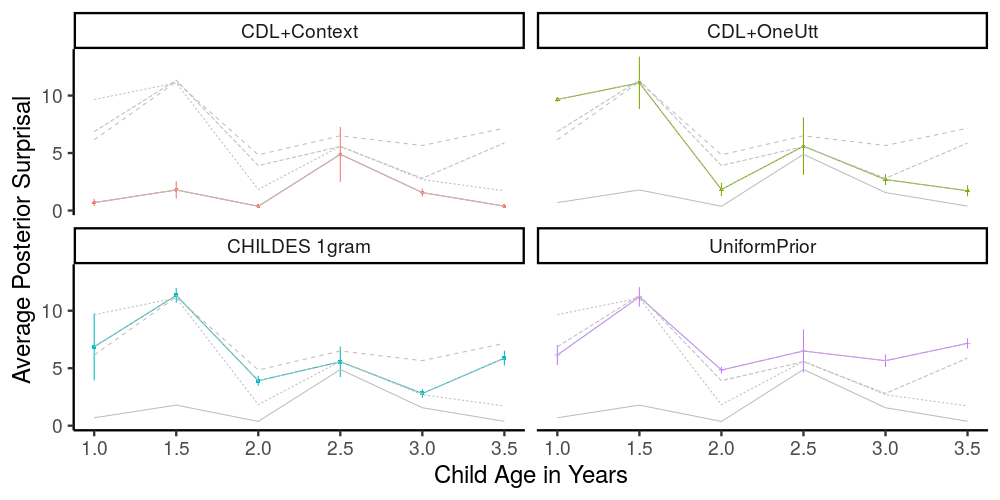

In [21]:
%%R -w 1000 -h 500

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


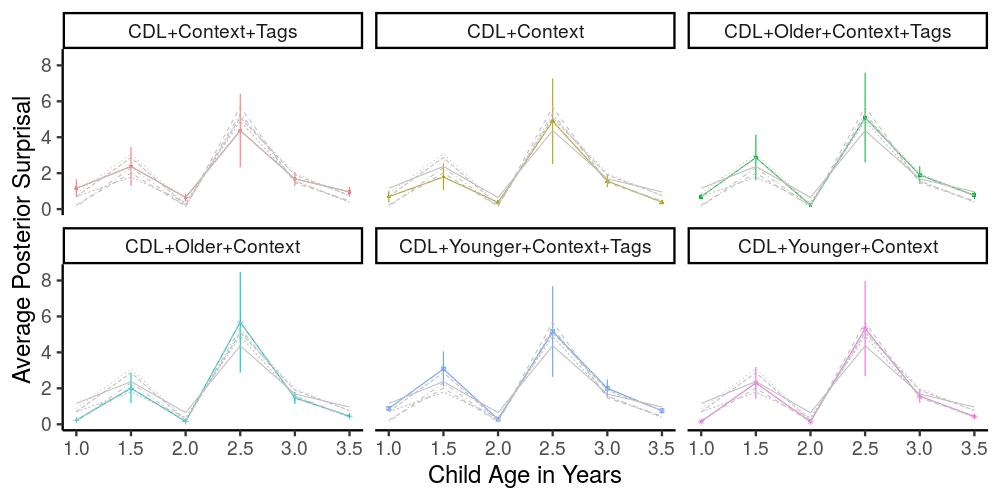

In [23]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


# Prior surprisal

In [27]:

%R mean_surprisal_by_age = aggregate(prior_probability ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_probability ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 


,age,model,prior_surprisal_mean,prior_surprisal_sem
1,1.5,BERT+Context,3.251393,2.354744
2,1.5,BERT+OneUtt,13.024786,3.981447
3,1.5,CDL+Context,2.991109,2.757028
4,1.5,CDL+Context+Tags,3.919252,3.727306
5,1.5,CDL+Older+Context,2.586796,2.429935
...,...,...,...,...
92,3.0,CDL+Younger+Context+Tags,4.045729,0.878109
93,3.0,CDL+Younger+OneUtt,5.599800,0.984035
94,3.0,CDL+Younger+OneUtt+Tags,5.258948,0.988805
95,3.0,CHILDES 1gram,7.833092,0.709398


### Prior Surprisal Across Ages

In [28]:
%%R -w 1000 -h 500
# Plot

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')

# Best performing CDL Context all/all, CHILDES 1gram and Uniform Prior 


R[write to console]: Error in FUN(X[[i]], ...) : object 'posterior_surprisal_mean' not found



RRuntimeError: Error in FUN(X[[i]], ...) : object 'posterior_surprisal_mean' not found


In [29]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


R[write to console]: Error in FUN(X[[i]], ...) : object 'posterior_surprisal_mean' not found



RRuntimeError: Error in FUN(X[[i]], ...) : object 'posterior_surprisal_mean' not found


In [31]:
scores_across_time_short.set.value_counts()

success    592
failure    192
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [33]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,1.5,BERT+Context,failure,4.112180,0.858061
2,1.5,BERT+Context,success,2.109468,0.698697
3,1.5,BERT+OneUtt,failure,2.905027,0.503229
4,1.5,BERT+OneUtt,success,3.274318,1.022311
5,1.5,CDL+Context,failure,3.513064,1.390297
...,...,...,...,...,...
188,3.0,CDL+Younger+OneUtt+Tags,success,1.041529,0.330757
189,3.0,CHILDES 1gram,failure,2.635838,0.261928
190,3.0,CHILDES 1gram,success,2.930234,0.305860
191,3.0,UniformPrior,failure,5.055491,0.009660


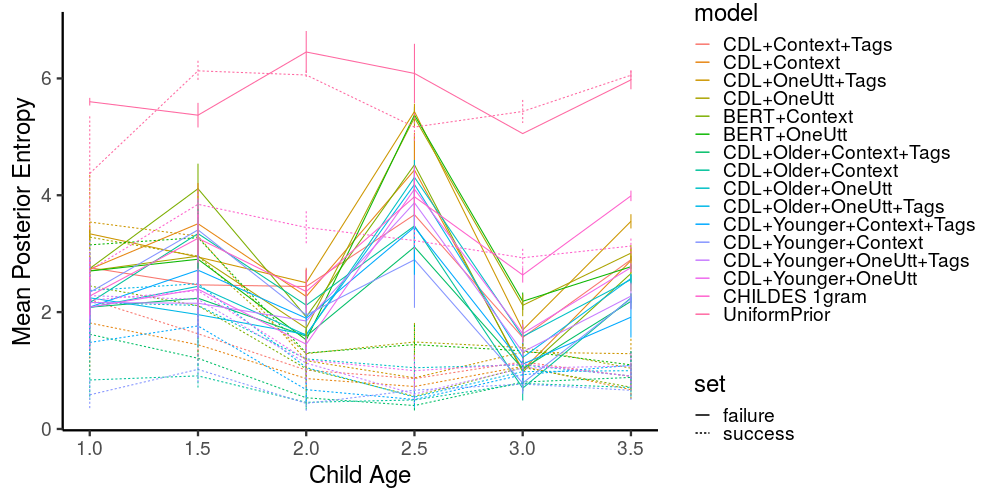

In [34]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [35]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [36]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age                  model      gain gain_sem comparison age_in_months
1 1.5           BERT+Context 11.463592 1.116560  posterior            18
2 1.5            BERT+OneUtt  9.985353 2.010317  posterior            18
3 1.5            CDL+Context 12.656796 1.617990  posterior            18
4 1.5       CDL+Context+Tags 12.636086 1.745092  posterior            18
5 1.5      CDL+Older+Context 16.114610 0.957188  posterior            18
6 1.5 CDL+Older+Context+Tags 15.599468 1.407734  posterior            18


In [37]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

   age        model     gain  gain_sem comparison age_in_months
16 1.5 UniformPrior 4.513345 0.4539636  posterior            18
32 1.0 UniformPrior 5.233950 0.1983051  posterior            12
48 2.5 UniformPrior 5.856998 0.8646031  posterior            30
64 2.0 UniformPrior 5.080584 0.3913178  posterior            24
80 3.5 UniformPrior 5.697424 0.2426444  posterior            42
96 3.0 UniformPrior 5.950027 0.2987817  posterior            36


In [38]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [39]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

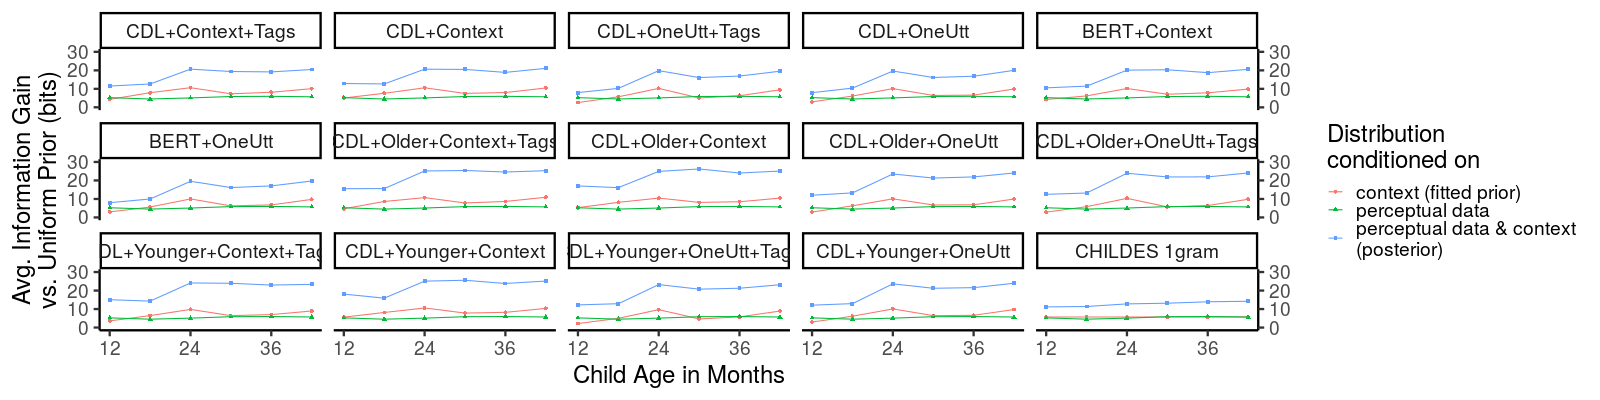

In [40]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# 12 Posterior Probability as a function of edit distance

In [43]:
%%R
surprisal_by_edit_distance = aggregate(posterior_probability ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_probability ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)


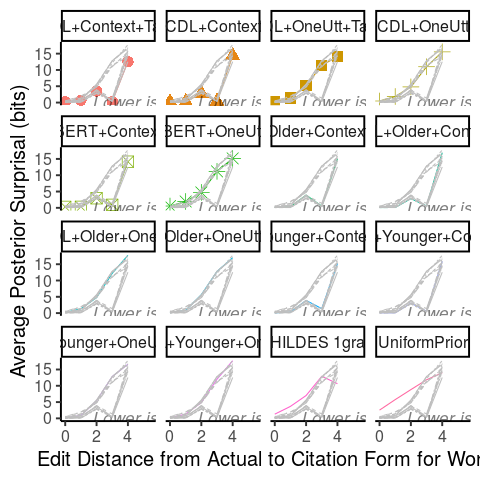

In [48]:
%%R

surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, edit_distance <= 6)

surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=surprisal_for_gray, aes(x=edit_distance,y=mean_posterior_surprisal, linetype = line_model),colour='gray', alpha=1)+
theme(legend.position='none')

ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [50]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


   edit_distance                  model mean_posterior_surprisal
1              0           BERT+Context               0.29265985
2              0            BERT+OneUtt               0.54696805
3              0            CDL+Context               0.22346407
4              0       CDL+Context+Tags               0.23401813
5              0      CDL+Older+Context               0.09199878
6              0 CDL+Older+Context+Tags               0.10156695
7              0       CDL+Older+OneUtt               0.22449385
8              0  CDL+Older+OneUtt+Tags               0.12413896
9              0             CDL+OneUtt               0.47648225
10             0        CDL+OneUtt+Tags               0.29677118
   mean_posterior_surprisal_sem       high        low unigram_prior_prob
1                    0.26286732 0.29265985 0.29265985           2.539929
2                    0.41118933 0.54696805 0.54696805           2.539929
3                    0.19286095 0.22346407 0.22346407           2.

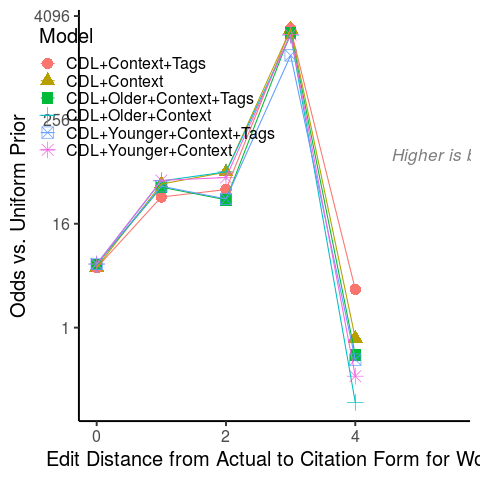

In [52]:
%%R

subset_surprisal_by_edit_distance <- filter_model_subset(surprisal_by_edit_distance, splits_tags_set)

p2= ggplot(subset(subset_surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale_subset.pdf', height=6, width=8)    
print(p2)

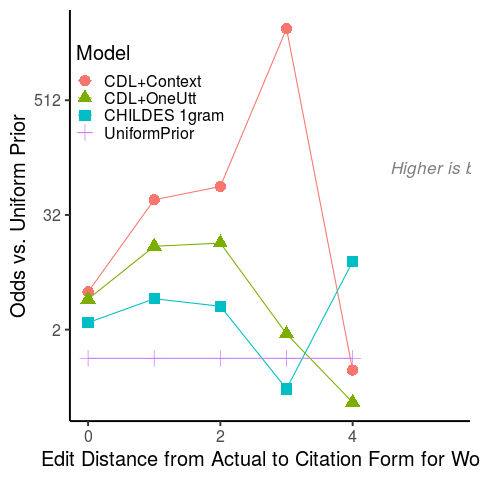

In [53]:
%%R

overview_surprisal_by_edit_distance <- filter_model_subset(surprisal_by_edit_distance, overview_set)

p2= ggplot(subset(overview_surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale_overview.pdf', height=6, width=8)    
print(p2)

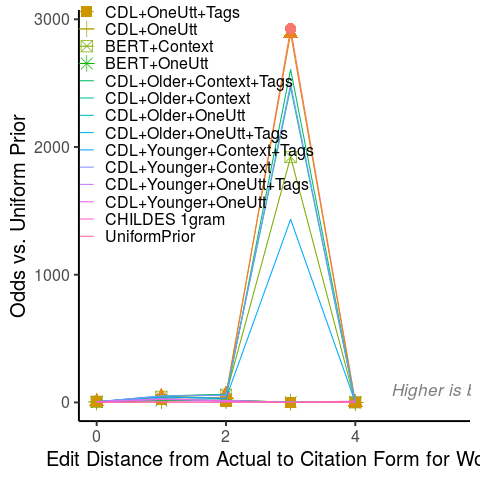

In [54]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [33]:
%%R
library(plotROC)

In [64]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 43800 15510


In [65]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

[1] "CDL+Context+Tags"         "CDL+Context"             
[3] "CDL+Younger+Context+Tags" "CDL+Younger+Context"     
[5] "CDL+Older+Context+Tags"   "CDL+Older+Context"       


In [66]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



In [70]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 3),')')

In [71]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "CDL+Context (AUC = 0.868)" "CDL+Context (AUC = 0.868)"
 [3] "CDL+Context (AUC = 0.868)" "CDL+Context (AUC = 0.868)"
 [5] "CDL+Context (AUC = 0.868)" "CDL+Context (AUC = 0.868)"
 [7] "CDL+Context (AUC = 0.868)" "CDL+Context (AUC = 0.868)"
 [9] "CDL+Context (AUC = 0.868)" "CDL+Context (AUC = 0.868)"


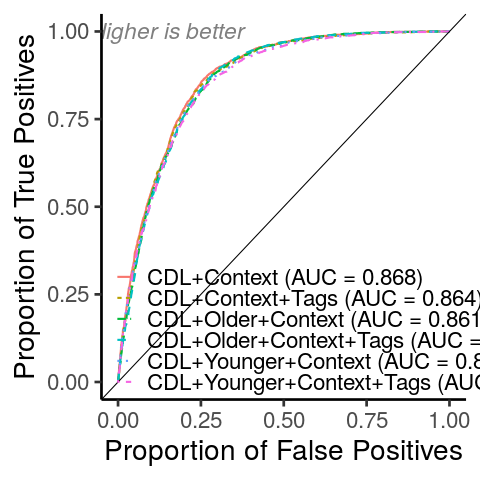

In [72]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=12, width=12)    